In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np

In [114]:
import sys
print(f"Python {sys.version}")
print(sys.executable)

Python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
c:\Users\ibrah\anaconda3\anaconda4\python.exe


In [36]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
data = pd.read_parquet("hf://datasets/Kwaai/IMDB_Sentiment/" + splits["train"])

In [37]:
data.columns = ["review","sentiment"]

In [40]:
data["review"] = data["review"].str.replace('<br />',' ')

##### Import libraries for text manipulation

In [41]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  
from sklearn.model_selection import train_test_split

### Matrice documents X terme 

-  CountVectorizer
-  TfidfVectorizer : *TF-IDF : accorde plus d'importance aux mots rares dans le corpus, et moins aux mots trop fréquents*.

- Matrice Sparce :
    - Les lignes représentent les documents (chaque ligne = un texte du corpus).
    - Les colonnes représentent les mots du vocabulaire (chaque colonne = un mot unique).
    -  si la matrice X a une dimension (n_documents, n_mots)
    - X[i, j] contient la valeur associée au mot j dans le document i (par exemple, le nombre d'occurrences du mot dans le document si on utilise CountVectorizer).

In [44]:
vectorisation = CountVectorizer(stop_words='english', max_features=500, lowercase=True, min_df=20, encoding='utf-8')
X = vectorisation.fit_transform(data["review"])
df = pd.DataFrame(X.toarray(), columns=vectorisation.get_feature_names_out())
df.shape 

(25000, 500)

### Mots les plus Frequents

*vectorisation.vocabulary_.items() vectorisation.vocabulary_ est un dictionnaire {mot: index} qui mappe chaque mot à son index dans la matrice X.
.items() retourne une liste de tuples (mot, index).*
*X.getcol(i) permet d'extraire une colonne spécifique i d'une matrice creuse sous forme d'une matrice colonne. Cette colonne correspond aux occurrences du mot (word) dans tous les documents.; .sum() calcule la somme des occurrences du mot dans tout le corpus (ou la somme des scores si X est une matrice TF-IDF).*


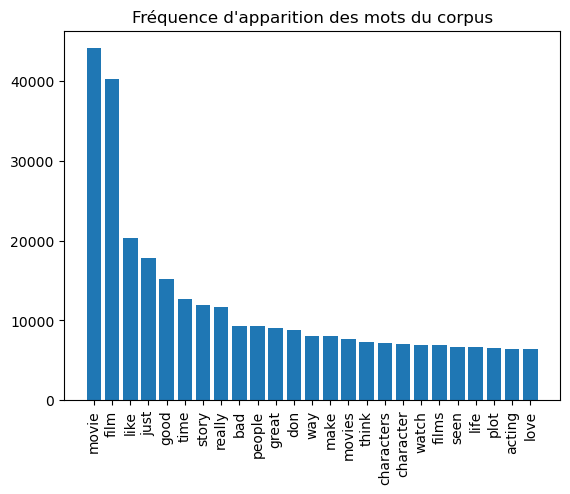

In [45]:
freqs = [(word, X.getcol(idx).sum()) for word, idx in vectorisation.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:25]], [x[1] for x in freqs[:25]])
plt.xticks(rotation=90)
plt.title("Fréquence d'apparition des mots du corpus")
plt.show()

### AFC

In [64]:
from sklearn.decomposition import FactorAnalysis
n_components = 2
fa = FactorAnalysis(n_components=n_components)
fa.fit(df)

FactorAnalysis(n_components=2)

##### Affichage des variables 

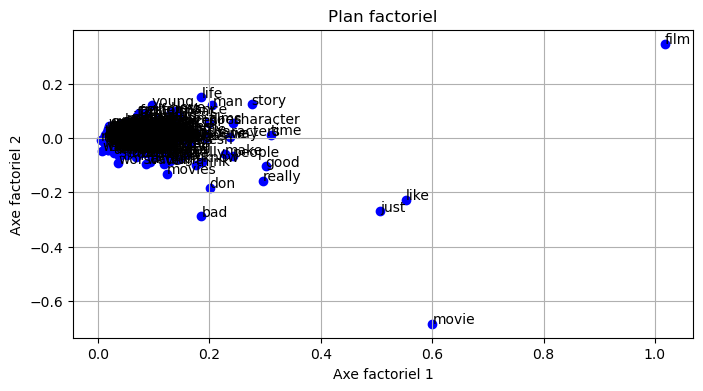

In [65]:
plt.figure(figsize=(8,4))
plt.scatter(fa.components_[0], fa.components_[1],color='blue')
for i, var in enumerate(df.columns):
    plt.annotate(var, (fa.components_[0][i], fa.components_[1][i]), color='black')
plt.xlabel("Axe factoriel 1")
plt.ylabel("Axe factoriel 2")
plt.title("Plan factoriel")
plt.grid()
plt.show()

Affichage des individus 

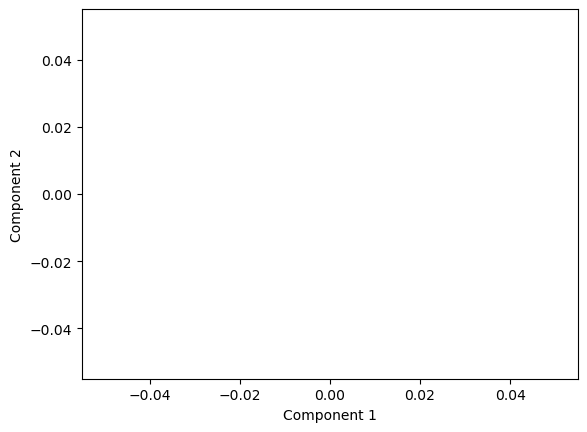

In [66]:
components = fa.transform(df)
df_components = pd.DataFrame(components, columns=['Component_1', "Component_2"])
df_components["sentiment"]=data["sentiment"]
colors = {'0':'red','1':'blue'}

plt.scatter(df_components['Component_1'], df_components['Component_2'], c=df_components['sentiment'].map(colors), s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### Nuage des mots 

In [68]:
from wordcloud import WordCloud

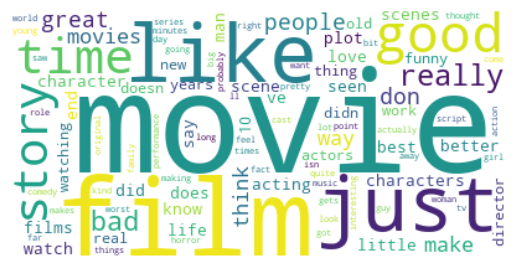

In [69]:
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Detection des thématiques

In [70]:
vec = TfidfVectorizer(decode_error='ignore', stop_words='english', max_features=500, lowercase=True, min_df=20, encoding='utf-8', strip_accents='unicode')
# max_features : top max_features ordered by term frequency across the corpus
X = vec.fit_transform(data["review"])

Liste des termes 

In [99]:
terms = vec.get_feature_names_out()
print(terms[:5])

['10' 'able' 'absolutely' 'act' 'acting']


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') # Il permet de tokenizer, d'identifier les parties du discours (POS) et de lemmatiser les mots.

#### Afficher les formes grammaticales

In [ ]:

data["review"].apply(lambda x: [(token.text, token.pos_, token.lemma_) for token in nlp(x)])

###### VARIANTE : pour traiter un grand nombre de lignes, il peut être plus efficace de traiter les données par lot avec la fonction nlp.pipe

### Detection des thématiques 

#### 1.  Latent Dirichlet Allocation  
- principe : Basé sur la probabilité bayésienne
- Matrice d'entrée : Matrice documents x termes
- Interprétation : Probabilités des topics
- Performances : 	Lent sur grands corpus
- Valeurs négatives : Autorisées (distribution de probabilité)

In [76]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=6, random_state=123, doc_topic_prior=0.2, n_jobs=4)

In [77]:
start_time = time.time()
lda_matrix = lda.fit_transform(X)
print("Temps de calcul :", time.time() - start_time)

Temps de calcul : 40.13581037521362


In [82]:
dominant_topics = lda_matrix.argmax(axis=1)
df = pd.DataFrame({'Topic': dominant_topics, 'sentiment': data['sentiment']})
cross_tab = pd.crosstab(df['sentiment'],df['Topic'])
print(cross_tab)
diagonal = cross_tab.values.diagonal()
accuracy = diagonal.sum() / cross_tab.values.sum()
print('\nAccuracy: %.3f' % accuracy)

Topic         0     1     2     3     4     5
sentiment                                    
0          2555  1677   773   847  3816  2832
1          1987  2559  3469  2540   468  1477

Accuracy: 0.205


**Liste des thématiques**

In [83]:
# Print the topics with their terms
terms = vec.get_feature_names_out()

# Get Components 
lda_components=lda.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['film', 'movie', 'like', 'just', 'man', 'people', 'story', 'good', 'really', 'life']
Topic 1:  ['film', 'movie', 'story', 'films', 'good', 'like', 'great', 'characters', 'character', 'version']
Topic 2:  ['movie', 'film', 'great', 'series', 'like', 'time', 'just', 'love', 'watch', 'episode']
Topic 3:  ['film', 'movie', 'man', 'role', 'story', 'performance', 'great', 'war', 'best', 'life']
Topic 4:  ['movie', 'bad', 'film', 'just', 'like', 'worst', 'acting', 'time', 'good', 'plot']
Topic 5:  ['movie', 'film', 'like', 'just', 'good', 'really', 'don', 'movies', 'bad', 'think']


In [87]:
# Modèle LDA avec 5 topics
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(X)

# Afficher les mots les plus représentatifs de chaque topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Thématique {topic_idx + 1}: ", end="")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Affichage des top mots par thématique
display_topics(lda, vec.get_feature_names_out(), 10)


Thématique 1: movie | series | film | great | like | time | episode | just | years | best
Thématique 2: film | movie | people | like | just | story | life | world | time | really
Thématique 3: movie | film | good | like | action | story | really | just | horror | effects
Thématique 4: film | movie | like | just | man | good | horror | scene | gets | killer
Thématique 5: movie | bad | just | film | like | don | movies | good | really | time
Thématique 6: film | movie | story | life | family | performance | love | great | young | man


**Affichage des thématiques**

In [84]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

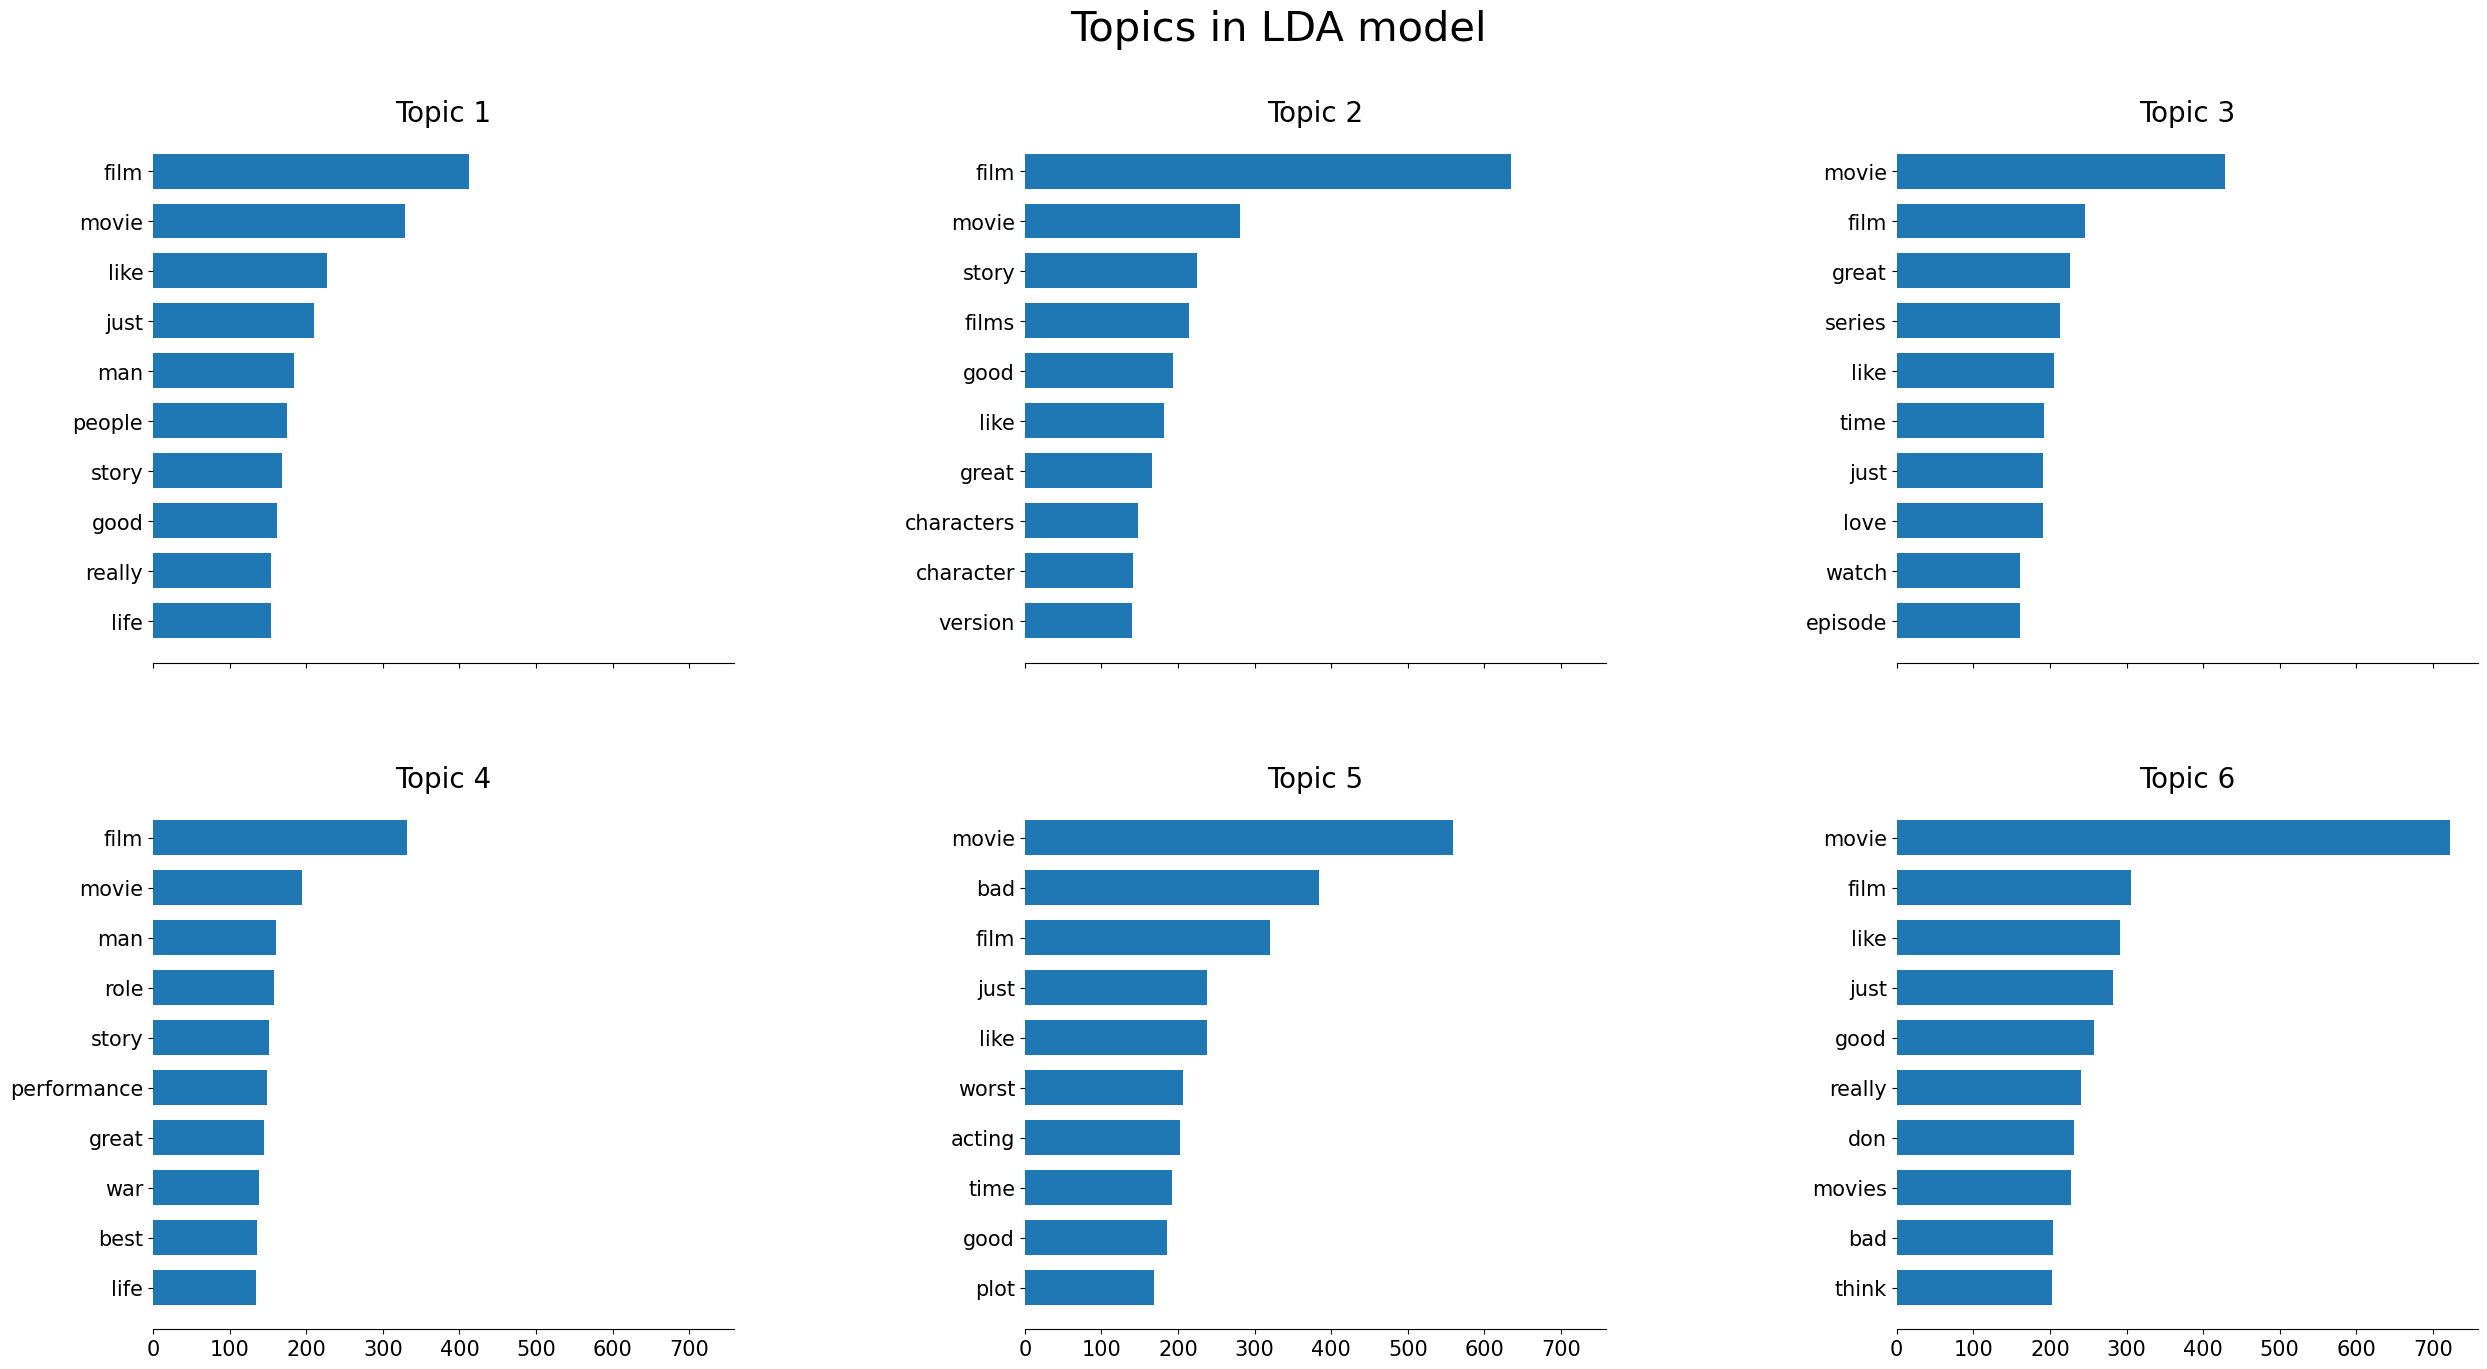

In [85]:
n_top_words = 10
plot_top_words(lda, terms, n_top_words, "Topics in LDA model")

### 2.  Non-negative Matrix Factorization

- principe : Basé sur l'algèbre linéaire
- Matrice d'entrée : Matrice TF-IDF ou documents x termes
- Interprétation : Décomposition additive des topics
- valeur negatives ? : Non (toutes les valeurs sont positives)
- Performances : 	Plus rapide et scalable

In [91]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=6, random_state=123, init="nndsvda", beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=1)
# train the model and use it to return a matrix where each row represents the topic distribution for a document in the original dataset
start_time = time.time()
nmf_matrix = nmf.fit_transform(X)
print("Temps de calcul :", time.time() - start_time)

Temps de calcul : 1.46134352684021


In [94]:
# nmf.get_params()

In [93]:
terms = vec.get_feature_names_out()
lda_components=nmf.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['film', 'films', 'horror', 'director', 'cinema', 'seen', 'making', 'acting', '10', 'able']
Topic 1:  ['movie', 'movies', 'watch', 'saw', 'recommend', 'great', 'book', 'watching', '10', 'did']
Topic 2:  ['story', 'great', 'time', 'like', 'character', 'life', 'love', 'characters', 'best', 'man']
Topic 3:  ['bad', 'just', 'like', 'don', 'really', 'movies', 'acting', 'worst', 'seen', 've']
Topic 4:  ['good', 'pretty', 'job', 'acting', '10', 'able', 'absolutely', 'act', 'action', 'actor']
Topic 5:  ['series', 'episode', 'episodes', 'tv', 'original', 'television', 'new', 'shows', 'characters', 'dvd']


In [97]:
display_topics(nmf,terms,10)

Thématique 1: film | films | horror | director | cinema | seen | making | acting | happened | genre
Thématique 2: movie | movies | watch | saw | recommend | great | book | watching | 10 | did
Thématique 3: story | great | time | like | character | life | love | characters | best | man
Thématique 4: bad | just | like | don | really | movies | acting | worst | seen | ve
Thématique 5: good | pretty | job | acting | happens | goes | game | gave | genre | george
Thématique 6: series | episode | episodes | tv | original | television | new | shows | characters | dvd


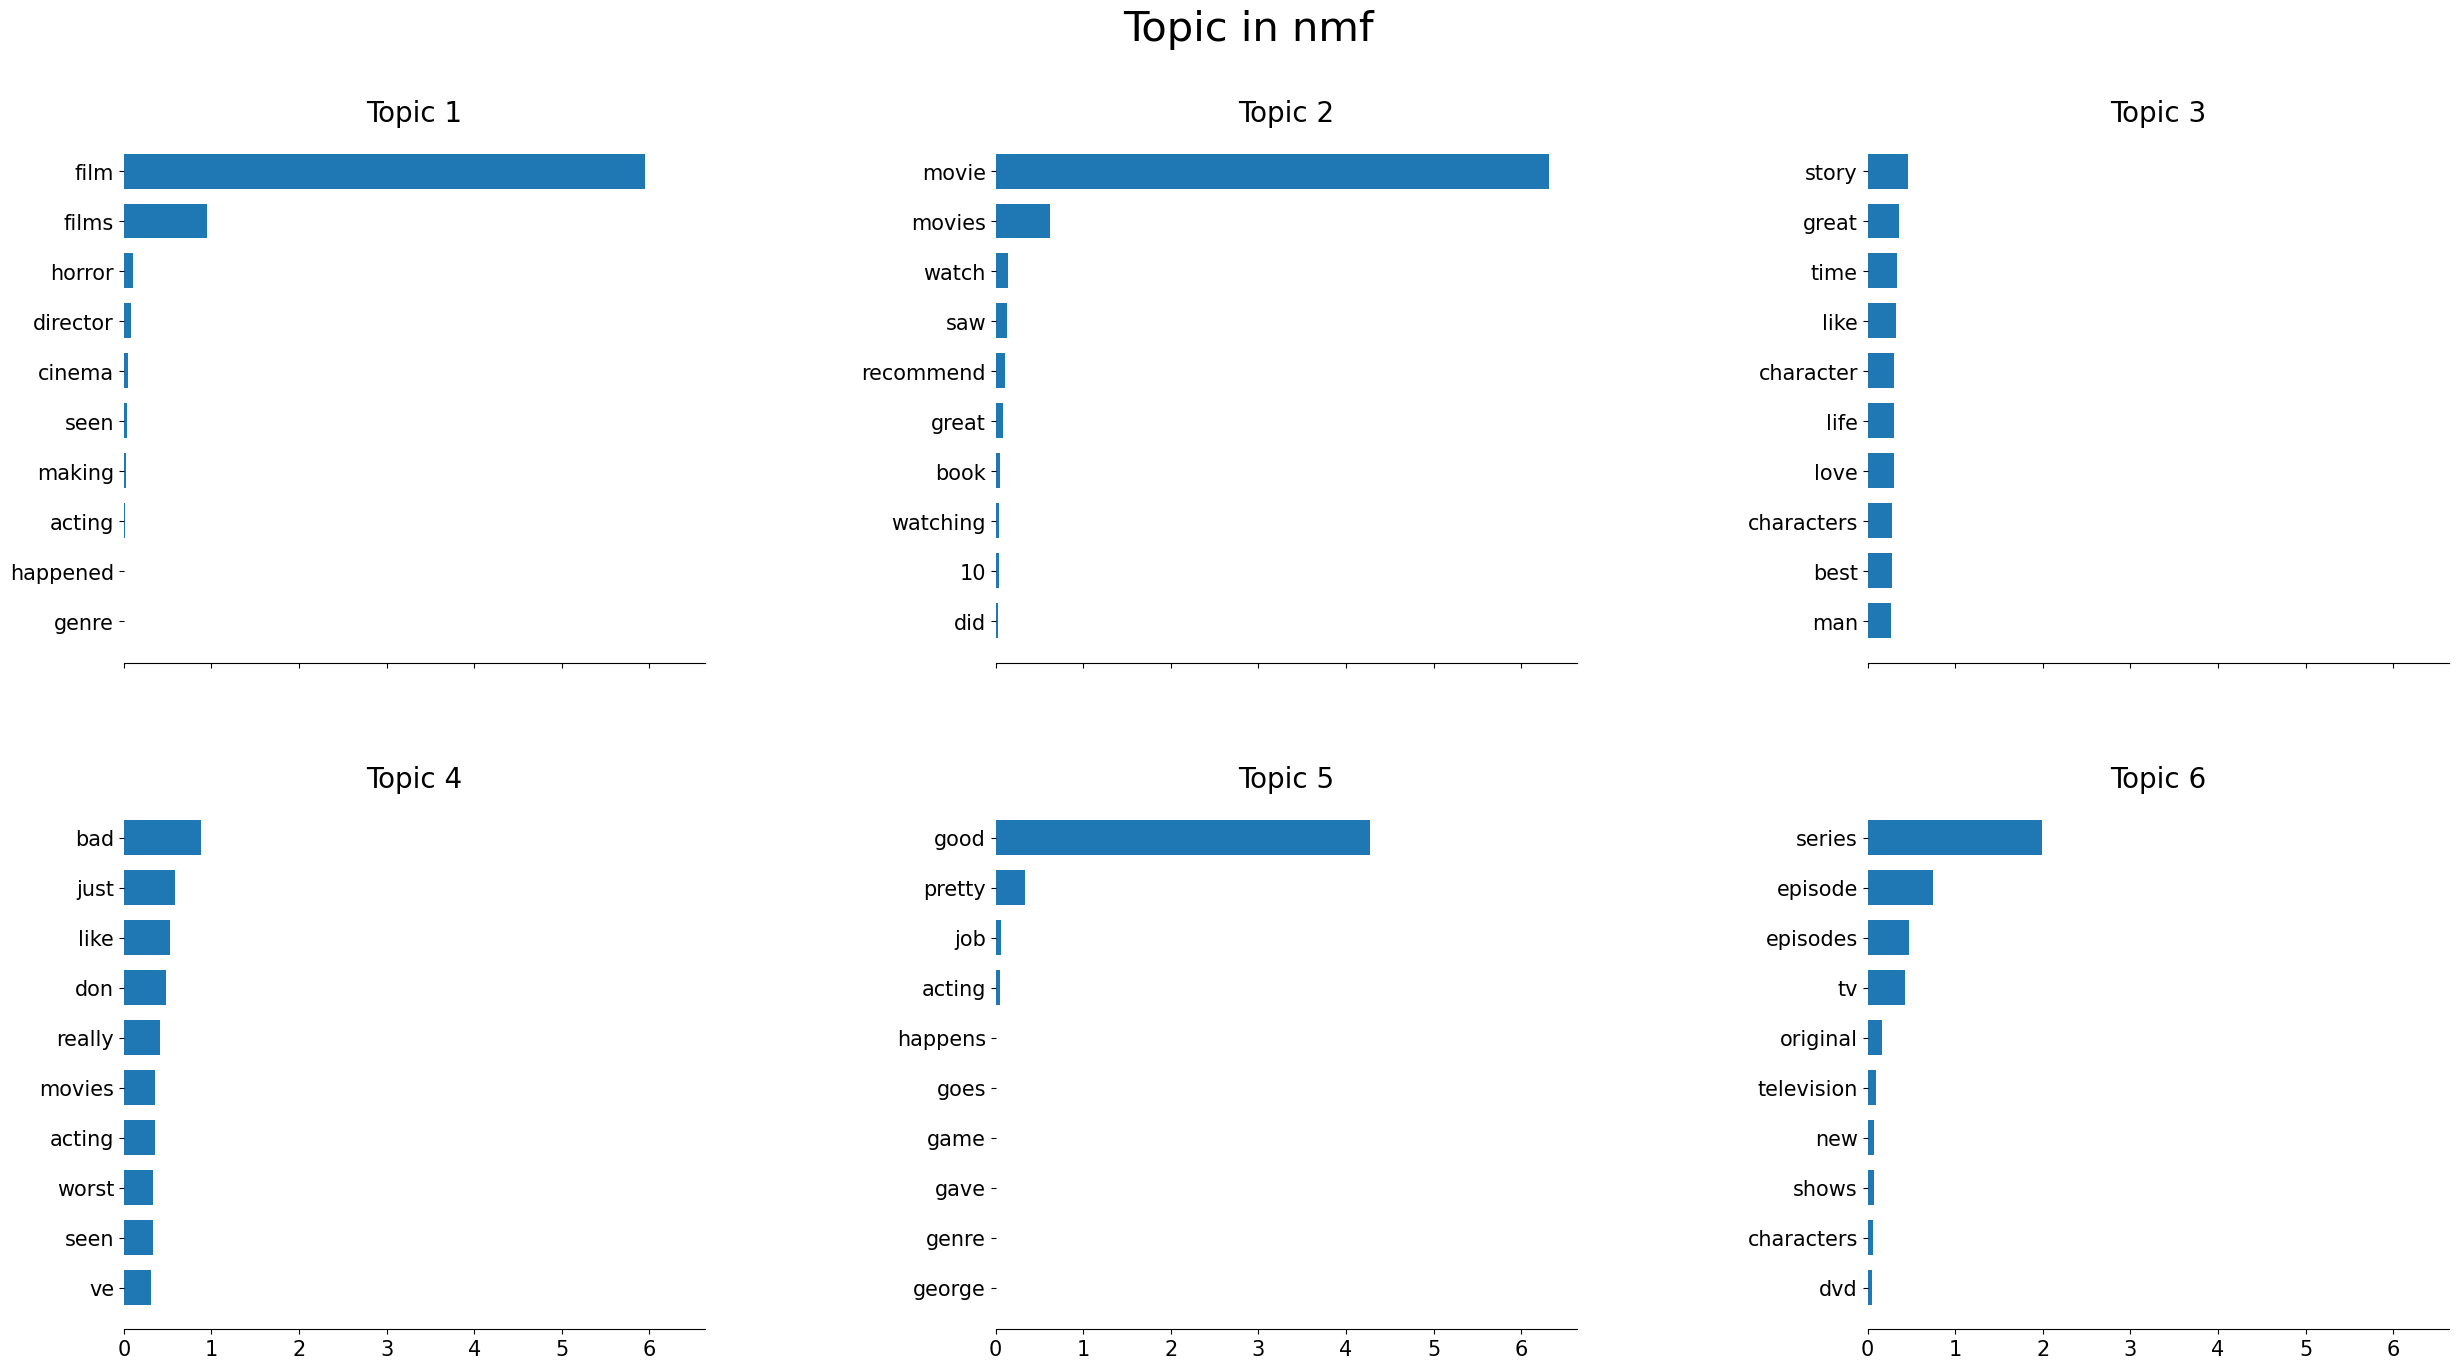

In [98]:
n_top_words = 10
plot_top_words(nmf,terms,n_top_words,"Topic in nmf")

Comparaison 
- LDA : Plus flou, mélange possible des sujets
- NMF : Séparation plus nette des thématiques
- NMF est plus déterministe et crée des topics bien séparés, alors que LDA, en raison de son approche probabiliste, tend à mélanger les thématiques, surtout si les sujets sont liés.
- Combiner NMF avec des embeddings (Word2Vec, TF-IDF pondéré) pour capturer plus de sens sémantique.

UMAP

In [101]:
import umap.umap_ as umap

In [102]:
# coordonnées de chaque document
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
embedding = umap.UMAP(n_neighbors=20, min_dist=0.2, n_components=3, random_state=235).fit_transform(df)
#embedding = umap.UMAP().fit_transform(df)
embedding.shape

c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(25000, 3)

In [105]:
y = data["sentiment"]
colors = ['red', 'green']
c = [colors[i] for i in y]

Tracer le graphique UMAP en 2D

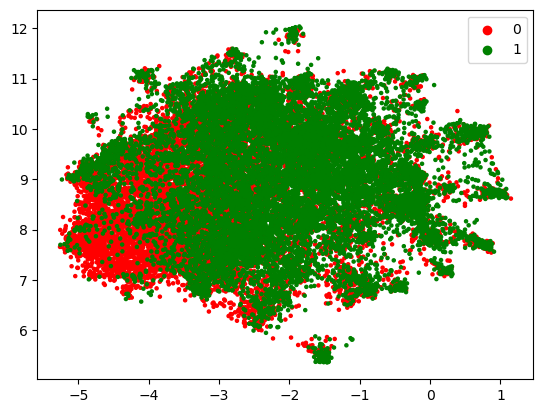

In [106]:

plt.scatter(embedding[:, 0], embedding[:, 1], c=c, s=5)

# Ajouter une légende pour chaque classe
for i, color in enumerate(colors):
    plt.scatter([], [], c=color, label=str(i))
plt.legend()

Tracer le graphique UMAP en 3D

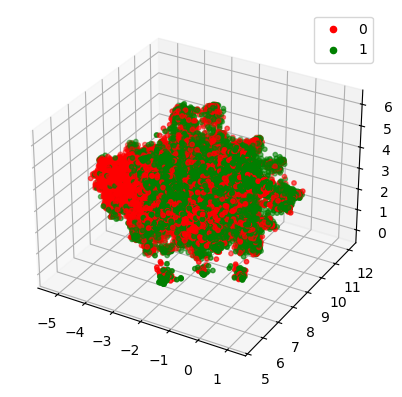

In [107]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=c, s=10)
    
# Ajouter une légende pour chaque classe
for i, color in enumerate(colors):
    ax.scatter([], [], c=color, label=str(i))
plt.legend()

### 3.LSA 
- Basé sur la decomposition en valeur premier
- TF-IDF ou CountVectorizer
- Quand utiliser LSA
    - Recherche d’information (moteurs de recherche, similarité entre documents).
    - Représentation vectorielle des textes (utilisé avant des modèles supervisés).
    - Pas idéal pour la détection de thématiques si les sujets sont bien séparés (NMF est meilleur).

In [110]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=6, n_iter=10, random_state=123)
start_time = time.time()
svd.fit(X)
print("Temps de calcul :", time.time() - start_time)

Temps de calcul : 0.2685987949371338


In [111]:
terms = vec.get_feature_names_out()

# Get Components 
lsa_components=svd.components_

for index, component in enumerate(lsa_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['movie', 'film', 'like', 'just', 'good', 'really', 'story', 'time', 'bad', 'great']
Topic 1:  ['movie', 'movies', 'bad', 'watch', 'don', 'funny', 'worst', 'just', 'good', 'watching']
Topic 2:  ['film', 'movie', 'bad', 'worst', 'acting', 'films', 'seen', 'horror', 'waste', 'plot']
Topic 3:  ['movie', 'film', 'great', 'story', 'love', 'life', 'best', 'performance', 'young', 'excellent']
Topic 4:  ['good', 'bad', 'acting', 'story', 'action', 'cast', 'plot', 'great', 'role', 'performance']
Topic 5:  ['great', 'series', 'watch', 'episode', 'best', 'funny', 'good', 'seen', 'tv', 'really']


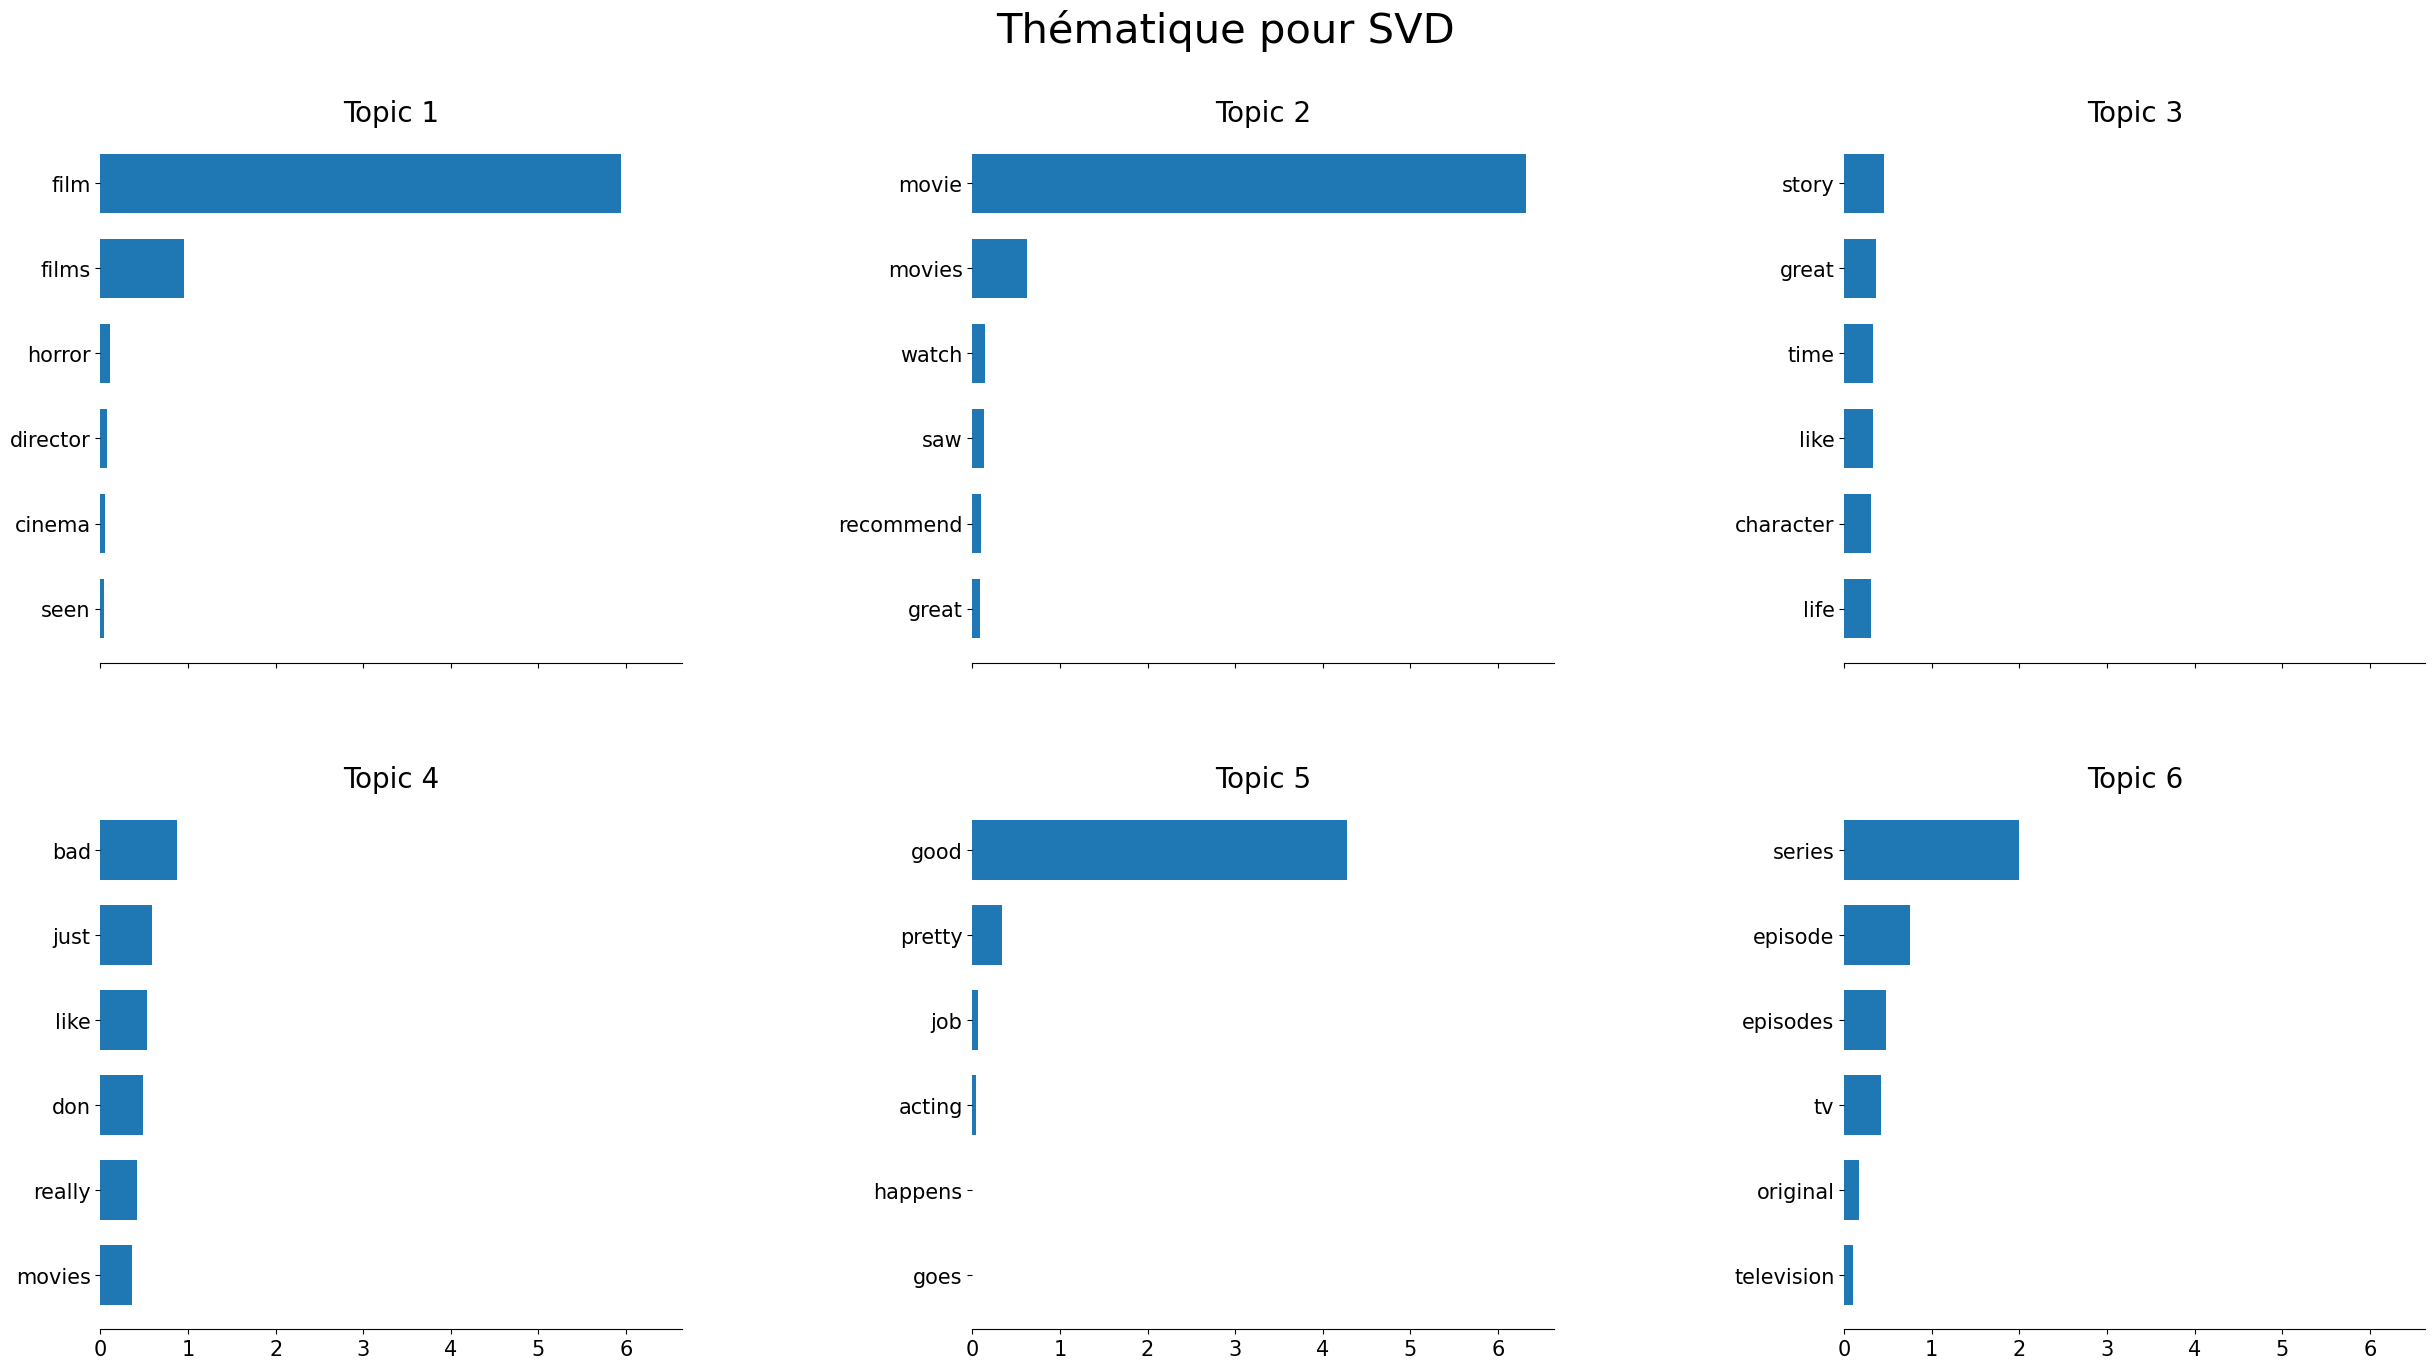

In [113]:
n_top_words=6
plot_top_words(svd, terms, n_top_words,"Thématique pour SVD")

Clustering 

In [116]:
from sklearn.cluster import KMeans

### nous cherchons a priori 6 clusters

In [117]:

nclusters = 6
kmeans = KMeans(n_clusters=nclusters, random_state=0)

In [118]:
kmeans.fit(X)

KMeans(n_clusters=6, random_state=0)

Evaluation 

In [119]:
y_kmeans = kmeans.predict(X)

l’indice Silhouette de Rousseeuw est entre -1 et +1  
the optimal value is 1, 0 indicates that clusters overlap and -1   indicates that the examples have been assigned to wrong groups.
from sklearn.metrics import silhouette_score

In [120]:
from sklearn.metrics import silhouette_score
silhouette_score(X, labels=y_kmeans)

0.008313244238299586

In [123]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=235, init='random').fit_transform(X)

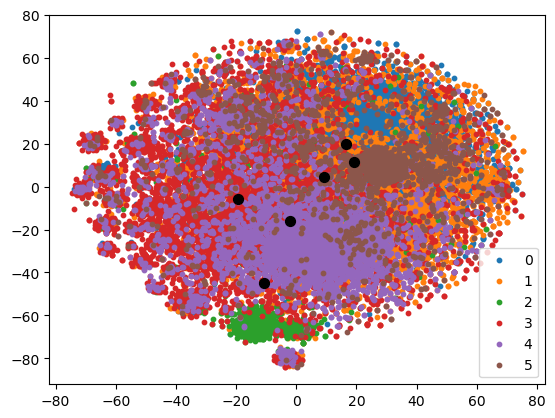

In [124]:
centroids_tsne = []
for i in range(0, nclusters):
    x = X_tsne[y_kmeans==i, 0]
    y = X_tsne[y_kmeans==i, 1]
    x_center = x.mean()
    y_center = y.mean()
    plt.scatter(x, y, label = i, s=10)
    centroids_tsne.append((x_center, y_center))
x_cent, y_cent = zip(*centroids_tsne)
plt.scatter(x_cent, y_cent, s=50, color='k')
plt.legend()
plt.show()

Nuage de mots par cluster

Cluster: 0
Titles


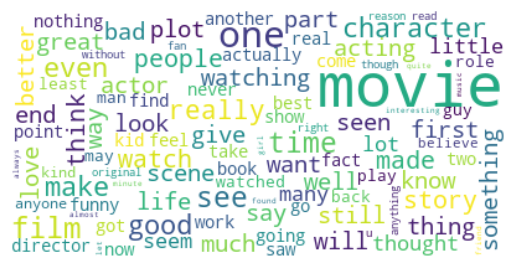

Cluster: 1
Titles


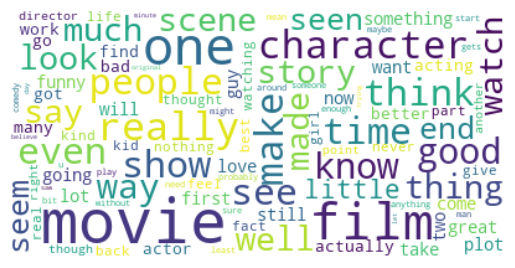

Cluster: 2
Titles


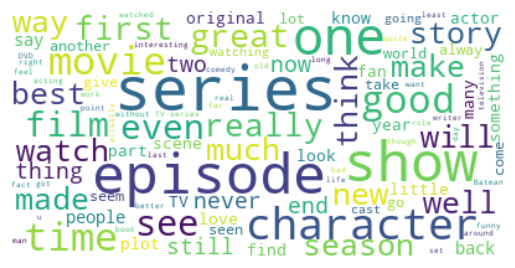

Cluster: 3
Titles


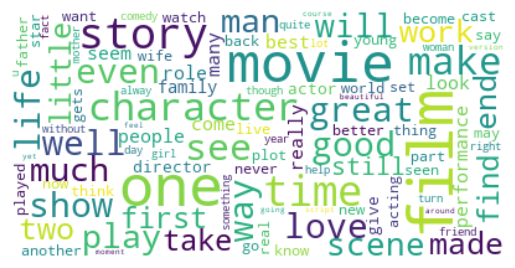

Cluster: 4
Titles


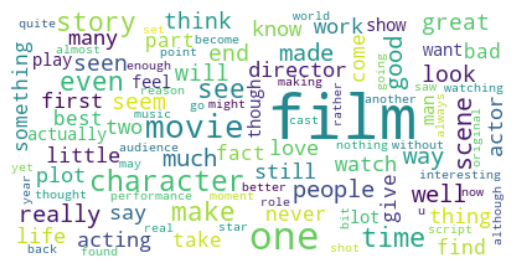

Cluster: 5
Titles


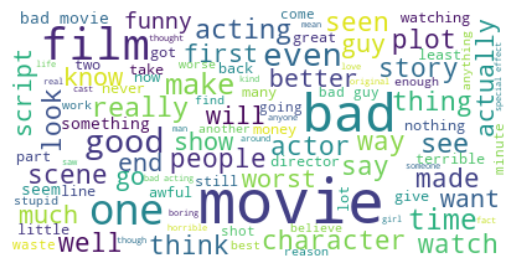

In [125]:
data["Label"] = y_kmeans
for k in range(0, nclusters):
   cl_data = data[data["Label"] == k]
   text = cl_data["review"].str.cat(sep=' ')
   text = ' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

Prediction 

In [126]:
def distance(doc, label):
    dist = np.linalg.norm(doc - kmeans.cluster_centers_[label])
    return dist

calcul de la distance entre chaque texte et son centroid

In [127]:
distances = []
for i, doc in enumerate(X):
    dist = distance(doc, y_kmeans[i])
    distances.append(dist)

In [128]:
data["Distance"] = distances
data = data.sort_values(by=["Label","Distance"])
data

,review,sentiment,Label,Distance
13523,"Once in a while, you come upon a movie that de...",1,0,0.772131
7239,The movie remains in the gray for far too long...,0,0,0.783433
10083,This movie must be in line for the most boring...,0,0,0.790305
20509,-Kidnappings in Mexico are as common as honeys...,1,0,0.791544
5896,Surprisingly enough does movie does have some ...,0,0,0.793501
...,...,...,...,...
24806,The first time you see The Second Renaissance ...,1,5,0.994828
1566,One of those el cheapo action adventures of th...,0,5,0.997352
9494,Impenetrable rubbish. This has to be one of th...,0,5,0.999186
4278,"I awake suddenly, aware that I'm drooling onto...",0,5,1.001252


Export

In [ ]:
# data.to_csv("topic_clustering.csv", sep=";", index=False)

## BERTopic
- pip install hdbscan / conda install -c conda-forge hdbscan
- pip install bertopic

In [129]:
from bertopic import BERTopic

Suppression les stopwords avant d'appliquer BERTopic

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r'\d+', '', text)  # Supprimer les nombres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Supprimer les stopwords
    return " ".join(words)

# Nettoyer les avis avant de les passer à BERTopic
data["review_cleaned"] = data["review"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibrah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [180]:
topic_model = BERTopic(nr_topics=6)
topics, probabilities = topic_model.fit_transform(data["review_cleaned"])

Réduction du nombre de thématiques

In [181]:
topic_model.reduce_topics(data['review_cleaned'], nr_topics=20)

- Liste des thématiques
- la thématique -1 correspond à tous les outliers

In [182]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13830,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...
1,0,10927,0_movie_film_one_like,"[movie, film, one, like, good, story, time, ev...",[film crew shooting horror movie old supposedl...
2,1,135,1_earth_film_planet_documentary,"[earth, film, planet, documentary, surfing, so...",[riding giants brilliant documentary dives dee...
3,2,65,2_che_chavez_puerto_part,"[che, chavez, puerto, part, coup, documentary,...",[neatly skipping everything coup cuba undercov...
4,3,29,3_match_wwe_vs_championship,"[match, wwe, vs, championship, cena, ring, ben...",[wwe armageddon december live richmond coliseu...
5,4,14,4_karloff_lugosi_rukh_benet,"[karloff, lugosi, rukh, benet, dr, boris, ray,...",[boris karloff bela lugosi made many films tog...


- suppression des outliers

In [ ]:
# new_topics = topic_model.reduce_outliers(data['review_cleaned'], topics)
# topic_model.update_topics(data['review_cleaned'], topics=new_topics)

- Description de la thématique la plus fréquente

In [183]:
topic_model.get_topic(0)

[('movie', 0.03536533193671982),
 ('film', 0.03297845466865539),
 ('one', 0.02677265317768076),
 ('like', 0.020622580739210725),
 ('good', 0.0171435972100886),
 ('story', 0.015534463090480807),
 ('time', 0.015090154895084534),
 ('even', 0.014899711789596093),
 ('would', 0.014262373488885557),
 ('really', 0.014179397403886452)]

- description de la 2e thématique la plus fréquente

In [189]:
topic_model.get_topic(2)

[('che', 0.09497139807250614),
 ('chavez', 0.05614983631736621),
 ('puerto', 0.039634025140987024),
 ('part', 0.038678088162002716),
 ('coup', 0.03660438934163202),
 ('documentary', 0.03593103932944691),
 ('people', 0.03057476099471937),
 ('film', 0.02956018418053057),
 ('cuba', 0.028761096118339706),
 ('soderbergh', 0.028082566427043796)]

- Visualize top topic keywords

In [190]:
topic_model.visualize_barchart(top_n_topics=7)

- pour chaque document du corpus : sa thématique, sa probabilité, s'il est représentatif de la thématique...

In [186]:
topic_model.get_document_info(data['review_cleaned'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,come upon movie defines values shows true dept...,0,0_movie_film_one_like,"[movie, film, one, like, good, story, time, ev...",[film crew shooting horror movie old supposedl...,movie - film - one - like - good - story - tim...,1.000000,False
1,movie remains gray far long little gets explai...,0,0_movie_film_one_like,"[movie, film, one, like, good, story, time, ev...",[film crew shooting horror movie old supposedl...,movie - film - one - like - good - story - tim...,0.971574,False
2,movie must line boring movie years even woody ...,-1,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...,movie - film - one - like - good - even - woul...,0.000000,False
3,kidnappings mexico common honeys giving phone ...,-1,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...,movie - film - one - like - good - even - woul...,0.000000,False
4,surprisingly enough movie redeeming quality mo...,0,0_movie_film_one_like,"[movie, film, one, like, good, story, time, ev...",[film crew shooting horror movie old supposedl...,movie - film - one - like - good - story - tim...,0.196498,False
...,...,...,...,...,...,...,...,...
24995,first time see second renaissance may look bor...,-1,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...,movie - film - one - like - good - even - woul...,0.000000,False
24996,one el cheapo action adventures early used fil...,-1,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...,movie - film - one - like - good - even - woul...,0.000000,False
24997,impenetrable rubbish one worst movies ever see...,0,0_movie_film_one_like,"[movie, film, one, like, good, story, time, ev...",[film crew shooting horror movie old supposedl...,movie - film - one - like - good - story - tim...,1.000000,False
24998,awake suddenly aware im drooling onto plastic ...,-1,-1_movie_film_one_like,"[movie, film, one, like, good, even, would, re...",[one people go online see movie decide call wo...,movie - film - one - like - good - even - woul...,0.000000,False


- Visualize intertopic distance

In [187]:
topic_model.visualize_topics()